This notebook best viewed here: https://nbviewer.jupyter.org

This notebooke encompasses
- sending files to start varscan_pipeline on server
- maf filtering
- LD pruning to get SNPs for structure estimation in GEA

In [1]:
from pythonimports import *

# copy over fastq and md5 files to compute canada server

In [2]:
DIR = '/data/fastq/mengmeng/CoAdapTree_DouglasFir/received_2019_Sep10'
fastqs = fs(DIR, pattern='.fastq')
len(fastqs)

352

In [4]:
cmdtext = op.join(DIR, 'cp_to_graham_cmds.txt')
with open(cmdtext, 'w') as o:
    cmds = []
    for fastq in fastqs:
        cmds.append(f'rsync -avz {fastq} graham:/scratch/lindb/DF_pooled/')
    o.write("%s" % '\n'.join(cmds))

In [8]:
lview, dview = get_client('default')

56 56


In [9]:
def exe(cmd):
    import os
    os.system(cmd)

In [10]:
len(cmds)

352

In [11]:
jobs = make_jobs(cmds, exe, lview)
watch_async(jobs)

61
352


KeyboardInterrupt: 

In [12]:
cmdtext

'/data/fastq/mengmeng/CoAdapTree_DouglasFir/received_2019_Sep10/cp_to_graham_cmds.txt'

In [13]:
for j in jobs:
    x = j.r

In [18]:
needed = []
for cmd in cmds:
    fq = op.basename(cmd.split()[2])
    for x in ['NS.1195.001.D707---D504.DF_p54_cap25_kit3_R1.fastq.gz',
              'NS.1195.001.D707---D504.DF_p54_cap25_kit3_R2.fastq.gz',
              'NS.1195.001.D707---D505.DF_p85_cap27_kit3_R1.fastq.gz']:
        if fq == x:
            needed.append(cmd)
len(needed)

3

In [20]:
jobs = make_jobs(needed, exe, lview)
watch_async(jobs)

3
3


# filter for MAF

In [2]:
lview,dview = get_client('default')

56 56


In [3]:
def maf_filter(f):
    """filter MAF >= 0.01, write to file."""
    import pandas
    import os
    chunks = pandas.read_csv(f, sep='\t', chunksize=10000)
    dfs = []
    for chunk in chunks:
#         if len(dfs) % 5 == 0:
#             update([op.basename(f), len(dfs)])
        df = chunk[(chunk['AF'].astype(float) >= 0.01) & (chunk['AF'].astype(float) <= 0.99)].copy()
        df['MAF'] = df['AF']
        df.loc[df['AF'].astype(float) > 0.5, 'MAF'] = 1 - chunk['AF'][chunk['AF'].astype(float) > 0.5]
        dfs.append(df)
    
    df = pandas.concat(dfs)
    print(df.shape)
    
    out = f.replace(".txt", "_maf.txt").replace('02_baseline_filtered', '03_maf-p01_RD-recalculated')
    makedir(os.path.dirname(out))
    
    df.to_csv(out, sep='\t', index=False)
    print('done!')
dview['maf_filter'] = maf_filter
dview['makedir'] = makedir

In [4]:
# create dirs, get the baseline filtered files
DIR = '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA'
snpdir = op.join(DIR, 'DF_pooled/snpsANDindels')
basedir = op.join(snpdir, '02_baseline_filtered')
basefiles = [f for f in fs(basedir) if '.md5' not in f and 'INDEL' not in f]
basefiles

['/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/02_baseline_filtered/DF_pooled-varscan_all_bedfiles_PARALOGS.txt',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/02_baseline_filtered/DF_pooled-varscan_all_bedfiles_REPEATS.txt',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/02_baseline_filtered/DF_pooled-varscan_all_bedfiles_SNP.txt']

In [7]:
jobs = make_jobs(basefiles, maf_filter, lview)
watch_async(jobs)

3
3


# Recalcuate RD

Looking at our testdata (1 poolseq pop vs indSeq of same individuals), AD/DP was consistent with the frequency prediction from GATK. We saw that adjusting FREQ to AD / (AD + RD) decreased concordance between the two datasets. So that we are consistent with respect to uncorrected and corrected, I'm adjusting RD = DP - AD so we don't have to make adjustments in the future

In [1]:
from pythonimports import *

In [2]:
lview,dview = get_client()

51 51


In [17]:
DIR = '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/03_maf-p01_RD-recalculated'
files = fs(DIR, endswith='maf.txt', exclude='README')
files

['/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/03_maf-p01_RD-recalculated/DF_pooled-varscan_all_bedfiles_PARALOGS_maf.txt',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/03_maf-p01_RD-recalculated/DF_pooled-varscan_all_bedfiles_REPEATS_maf.txt',
 '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/03_maf-p01_RD-recalculated/DF_pooled-varscan_all_bedfiles_SNP_maf.txt']

In [6]:
# read in paralog and repeats, recalc RD
def recalc_rd(df):
    """Recalculate RD so RD = DP - AD."""
    rdcols = [col for col in df if '.RD' in col]
    for col in nb(rdcols):
        pop = col.split(".")[0]
        df[f'{pop}.RD'] = df[f'{pop}.DP'] - df[f'{pop}.AD']
    return df
    
dfs = {}
for f in files[:-1]:
    print(f)
    df = pd.read_table(f)
    dfs[f] = recalc_rd(df)

/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/03_maf-p01_RD-recalculated/DF_pooled-varscan_all_bedfiles_PARALOGS_maf.txt


100%|██████████| 87/87 [00:00<00:00, 4085.22it/s]


/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/03_maf-p01_RD-recalculated/DF_pooled-varscan_all_bedfiles_REPEATS_maf.txt


100%|██████████| 87/87 [00:00<00:00, 745.82it/s]


In [4]:
def get_skipto_df(f, skipto, nrows, cols=None):
    """Retrieve dataframe so that all rows are captured when iterating.
    
    f = filename to open
    skipto = row number to skip, read rows thereafter
    nrows = how many rows to read from f
    """
    import pandas
    
    if skipto == 0:
        df = pandas.read_table(f, nrows=nrows-1)
    else:
        df = pandas.read_table(f, skiprows=range(1, skipto), nrows=nrows)
    
    if cols is not None:
        if isinstance(cols, str):
            cols = [cols]
        df = df[cols].copy()
    
    return df
dview['get_skipto_df'] = get_skipto_df

In [5]:
# get linenums, includes header
linenums = {}
for f in files:
    out = !wc -l $f
    linenums[f] = int(out[0].split()[0])
    print(op.basename(f), linenums[f])

DF_pooled-varscan_all_bedfiles_PARALOGS_maf_RD-recalculated.txt 1629
DF_pooled-varscan_all_bedfiles_REPEATS_maf_RD-recalculated.txt 220443
DF_pooled-varscan_all_bedfiles_SNP_maf_RD-recalculated.txt 6728422


In [6]:
# read in SNPs in parallel, 
nrows = 50000
jobs = []
count = 0
for skipto in range(0, linenums[files[-1]], nrows):
    num = str(count).zfill(4)
    jobs.append(lview.apply_async(get_skipto_df, *(files[-1], skipto, nrows)))
    count += 1
watch_async(jobs)

135
135


In [ ]:
# recalc_rd for SNPs
dfs[files[-1]] = recalc_rd(pd.concat([j.r for j in jobs]))

In [11]:
for f,df in dfs.items():
    print(f)
    newf = f.replace("_maf.txt", "_maf_RD-recalculated.txt")
    print('\t', newf)
    df.to_csv(newf, sep='\t', index=False)

/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/03_maf-p01_RD-recalculated/DF_pooled-varscan_all_bedfiles_PARALOGS_maf.txt
	 /data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/03_maf-p01_RD-recalculated/DF_pooled-varscan_all_bedfiles_PARALOGS_maf_RD-recalculated.txt
/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/03_maf-p01_RD-recalculated/DF_pooled-varscan_all_bedfiles_REPEATS_maf.txt
	 /data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/03_maf-p01_RD-recalculated/DF_pooled-varscan_all_bedfiles_REPEATS_maf_RD-recalculated.txt
/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/03_maf-p01_RD-recalculated/DF_pooled-varscan_all_bedfiles_SNP_maf.txt
	 /data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/03_maf-p01_RD-recalculated/DF_pooled-varscan_all_bedfiles_SNP_maf_RD-recalculated.txt


# Choose SNPs for GEA structure correction in baypass

for SNPs with MAF > 0.01 and for all pops: 40 < DP < 1000, randomly choose one snp per contig (for contigs > 1Kbp), then LD prune so no pairwise r2 > 99.9th percentile of r2

#### get the snps

In [3]:
from pythonimports import *

def get_mafdict(afs, roundto):
    # bins for p52 depth
    mafs = [round(1-float(af),roundto) if float(af) > 0.5 else round(float(af),roundto) for af in afs]
    t = table(mafs)
    mafsdict = OrderedDict()
    for k in sorted(t):
        newk = '%.10f' % k
        if not newk in mafsdict:
            mafsdict[newk] = t[k]
        else:
            mafsdict[newk] += t[k]
    retdict = OrderedDict()
    for newk,count in mafsdict.items():
        retdict[newk] = count / sum(mafsdict.values())
    print(len(retdict.keys()))

    return retdict

def subcategorybar(X, vals, width=.9):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.xticks(_X, X)

def make_mafdict_fig(pruned_snpdict, all_snpdict, title=None):
    fig = plt.figure(figsize=(25,5))
    X = ['%.3f' % float(key) for key in sorted(keys(pruned_snpdict))]
    Y = [pruned_snpdict[freq] for freq in sorted(keys(pruned_snpdict))]
    Z = [all_snpdict[freq] for freq in sorted(keys(all_snpdict))]
    subcategorybar(X, [Y,Z])
    plt.legend(['pruned snps', 'all snps'],fontsize=20)
    plt.ylabel('proportion of SNPs in category',size=20)
    plt.xlabel('minor allele frequency',size=20)
    plt.title(title, size=20)
    plt.show()

In [4]:
lview,dview = get_client()

56 56


In [5]:
snpdir = '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels'

In [6]:
def filter_depth(*args):
    """Filter min/max depth, reduce columns."""
    chunk = get_skipto_df(*args)
    dpcols = [col for col in chunk.columns if '.DP' in col]
    freqcols = [col for col in chunk.columns if '.FREQ' in col]
    cols = ['CHROM', 'locus', 'AF', 'MAF'] + dpcols + freqcols
    chunk = chunk[cols].copy()
    for col in dpcols:
        chunk = chunk[chunk[col] >= 20].copy()
        chunk = chunk[chunk[col] < 1000].copy()
    chunk.index = chunk['locus'].tolist()
    return chunk

In [9]:
mafdir = op.join(snpdir, '03_maf-p01_RD-recalculated')
f = op.join(mafdir, 'DF_pooled-varscan_all_bedfiles_SNP_maf_RD-recalculated.txt')
op.exists(f)

True

In [26]:
out = !wc -l $f
out

['6728422 /data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/03_maf-p01/DF_pooled-varscan_all_bedfiles_SNP_maf.txt']

In [7]:
linenums = int(out[0].split()[0]) - 1
linenums

6728421


In [10]:
linenums = 6728421

In [12]:
# filter for depth in parallel as I read it in
nrows = 50000
jobs = []
for skipto in range(0, linenums, nrows):
    jobs.append(lview.apply_async(filter_depth, *(f, skipto, nrows)))
watch_async(jobs)

135
135


In [13]:
snps = pd.concat([j.r for j in jobs])
print(snps.shape)
snps.head()

(1995933, 178)


,CHROM,locus,AF,MAF,DF_p1.DP,DF_p18.DP,DF_p19.DP,DF_p2.DP,DF_p20.DP,DF_p23.DP,DF_p24.DP,DF_p25.DP,DF_p26.DP,DF_p27.DP,DF_p28.DP,DF_p10.DP,DF_p29.DP,DF_p3.DP,DF_p30.DP,DF_p31.DP,DF_p32.DP,DF_p33.DP,DF_p34.DP,DF_p35.DP,DF_p36.DP,DF_p37.DP,DF_p11.DP,DF_p38.DP,DF_p39.DP,DF_p4.DP,DF_p40.DP,DF_p41.DP,DF_p42.DP,DF_p43.DP,DF_p44.DP,DF_p45.DP,DF_p46.DP,DF_p12.DP,DF_p47.DP,DF_p48.DP,DF_p49.DP,DF_p5.DP,DF_p50.DP,DF_p51.DP,DF_p52.DP,DF_p53.DP,DF_p54.DP,DF_p55.DP,DF_p13.DP,DF_p56.DP,...,DF_p5.FREQ,DF_p50.FREQ,DF_p51.FREQ,DF_p52.FREQ,DF_p53.FREQ,DF_p54.FREQ,DF_p55.FREQ,DF_p13.FREQ,DF_p56.FREQ,DF_p57.FREQ,DF_p58.FREQ,DF_p59.FREQ,DF_p6.FREQ,DF_p60.FREQ,DF_p61.FREQ,DF_p62.FREQ,DF_p7.FREQ,DF_p72.FREQ,DF_p14.FREQ,DF_p73.FREQ,DF_p74.FREQ,DF_p75.FREQ,DF_p76.FREQ,DF_p77.FREQ,DF_p78.FREQ,DF_p79.FREQ,DF_p8.FREQ,DF_p80.FREQ,DF_p81.FREQ,DF_p15.FREQ,DF_p82.FREQ,DF_p83.FREQ,DF_p84.FREQ,DF_p85.FREQ,DF_p86.FREQ,DF_p87.FREQ,DF_p88.FREQ,DF_p89.FREQ,DF_p9.FREQ,DF_p90.FREQ,DF_p16.FREQ,DF_p91.FREQ,DF_p92.FREQ,DF_p93.FREQ,DF_p94.FREQ,DF_p95.FREQ,DF_p96.FREQ,DF_p97.FREQ,DF_p98.FREQ,DF_p17.FREQ
jcf7190000000004-54587,jcf7190000000004,jcf7190000000004-54587,0.105580,0.105580,76.0,52.0,69.0,31.0,35.0,48.0,72.0,65.0,52.0,67.0,41.0,62.0,78.0,59.0,55.0,41.0,61.0,64.0,71.0,64.0,54.0,37.0,58.0,49.0,45.0,60.0,22.0,42.0,26.0,67.0,67.0,57.0,53.0,75.0,51.0,57.0,66.0,51.0,52.0,57.0,69.0,62.0,66.0,67.0,59.0,55.0,...,19.61%,15.38%,42.11%,37.68%,NaN,0%,5.97%,NaN,14.55%,NaN,16.67%,4.35%,1.72%,2.7%,17.39%,NaN,22.22%,10.14%,21.88%,20.69%,8.51%,22.81%,5.97%,13.58%,8.97%,2.99%,27.91%,NaN,18.97%,1.92%,10.39%,10.34%,NaN,0%,6.98%,3.7%,NaN,1.61%,NaN,NaN,5.97%,12.86%,4.55%,6.67%,9.52%,NaN,0%,26.56%,15.28%,NaN
jcf7190000000004-54589,jcf7190000000004,jcf7190000000004-54589,0.889279,0.110721,75.0,52.0,68.0,31.0,35.0,46.0,74.0,67.0,50.0,67.0,41.0,60.0,78.0,60.0,55.0,41.0,60.0,65.0,69.0,61.0,58.0,38.0,57.0,46.0,46.0,60.0,22.0,40.0,26.0,68.0,67.0,59.0,51.0,73.0,51.0,58.0,65.0,47.0,51.0,56.0,69.0,63.0,66.0,67.0,59.0,54.0,...,100%,84.31%,89.29%,89.86%,61.9%,100%,97.01%,77.97%,100%,100%,100%,100%,91.53%,95.95%,100%,100%,98.41%,63.38%,76.19%,72.88%,86.36%,91.38%,65.67%,93.67%,80.52%,72.31%,97.73%,74.36%,79.31%,72.22%,79.73%,81.61%,58.97%,100%,100%,100%,100%,96.88%,100%,68.63%,76.12%,84.29%,95.38%,83.33%,100%,76.19%,61.76%,82.81%,97.26%,86.36%
jcf7190000000004-54619,jcf7190000000004,jcf7190000000004-54619,0.033857,0.033857,77.0,56.0,67.0,33.0,32.0,50.0,69.0,75.0,66.0,69.0,47.0,65.0,64.0,64.0,58.0,50.0,63.0,63.0,70.0,58.0,63.0,34.0,60.0,46.0,47.0,62.0,25.0,37.0,26.0,70.0,63.0,57.0,56.0,70.0,52.0,54.0,60.0,48.0,55.0,53.0,59.0,61.0,67.0,69.0,70.0,71.0,...,8.33%,0%,0%,0%,0%,NaN,4.35%,0%,4.23%,21.67%,1.35%,8.7%,0%,NaN,0%,15.15%,NaN,2.74%,0%,0%,0%,0%,0%,0%,0%,0%,4.17%,0%,0%,0%,0%,0%,0%,2.99%,0%,7.84%,10.81%,6.35%,12.5%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%,0%
jcf7190000000004-54623,jcf7190000000004,jcf7190000000004-54623,0.065287,0.065287,77.0,57.0,63.0,34.0,31.0,53.0,68.0,78.0,64.0,67.0,49.0,65.0,66.0,65.0,57.0,49.0,64.0,65.0,71.0,59.0,64.0,34.0,60.0,44.0,45.0,63.0,24.0,34.0,26.0,69.0,63.0,59.0,56.0,70.0,55.0,53.0,60.0,46.0,52.0,52.0,56.0,59.0,69.0,67.0,70.0,70.0,...,15.22%,0%,0%,0%,0%,NaN,17.91%,0%,NaN,28.33%,44.74%,4.35%,0%,21.92%,16.67%,1.47%,11.76%,0%,0%,0%,0%,7.14%,0%,0%,0%,0%,15.56%,0%,0%,0%,0%,0%,0%,10.45%,10.53%,18%,2.7%,20.34%,21.43%,0%,0%,0%,0%,0%,21.95%,0%,0%,0%,0%,0%
jcf7190000000004-54643,jcf7190000000004,jcf7190000000004-54643,0.246071,0.246071,68.0,56.0,57.0,34.0,27.0,49.0,53.0,76.0,61.0,72.0,56.0,61.0,66.0,63.0,62.0,47.0,64.0,66.0,77.0,58.0,64.0,33.0,55.0,38.0,42.0,63.0,27.0,35.0,24.0,67.0,66.0,56.0,59.0,68.0,59.0,52.0,51.0,46.0,47.0,50.0,49.0,65.0,60.0,62.0,76.0,76.0,...,8.7%,23.4%,8%,28.57%,18.46%,25%,16.13%,21.05%,26.32%,39.29%,16.44%,32.56%,14.29%,13.33%,16.33%,41.1%,35.38%,25.33%,15.71%,13.56%,37.78%,1.54%,18.46%,22.22%,30%,21.05%,58.14%,NaN,12.12%,19.12%,19.48%,27.91%,9.76%,34.21%,29.55%,15.09%,37.5%,21.05%,42.86%,NaN,20.27%,28.79%,26.32%,13.21%,8.7%,14.94%,12.5%,22.06%,30%,NaN


In [23]:
luni(snps['CHROM'])

25448

In [24]:
f

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/03_maf-p01/DF_pooled-varscan_all_bedfiles_SNP_maf.txt'

#### reduce those snps on contigs > 1Kbp

In [25]:
# get contig lengths
lengths = pd.read_table('/data/database/DouglasFir_ref_genome/DF_ref_edit.fasta.length', header=None)
lengths.head()

,0,1
0,jcf7190000000000,104664
1,jcf7190000000004,713351
2,jcf7190000000008,780568
3,jcf7190000000009,80234
4,jcf7190000000010,335878


In [26]:
lens = dict((contig,length) for (contig,length) in zip(lengths[0],lengths[1]) if length>1000)
len(lens.keys())

79910

In [108]:
freqcols = [col for col in snps.columns if '.FREQ' in col]
reduced = snps[snps['CHROM'].isin(list(lens.keys()))].copy()
reduced = reduced.loc[:, freqcols + ['CHROM', 'AF', 'MAF']]
reduced.shape, snps.shape

((1987784, 90), (1995933, 178))

In [66]:
min(lens.values())

1001

50
50


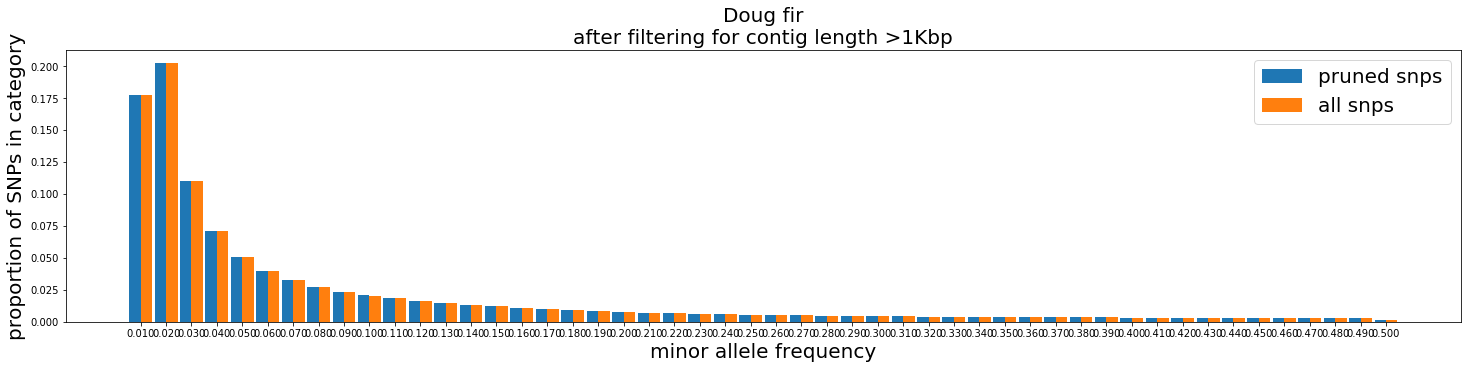

In [109]:
make_mafdict_fig(get_mafdict(reduced['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir\nafter filtering for contig length >1Kbp')

#### reduce to no missing data  (can't, MAF spectrum doesn't match well with MAF spectrum of all data. Filter for % missing below)

In [107]:
# lview,dview = get_client()

5 5


In [108]:
# def reduce_col(col):
#     """Return list of loci with no missing data for pop.FREQ col."""
#     return reduced[~reduced[col].isnull()].index

# dview['reduced'] = reduced

In [ ]:
# # jobs = []
# # for col in nb(freqcols):
# #     jobs.append(reduce_col(col))

In [109]:
# # send jobs to reduce_col
# freqcols = [col for col in reduced.columns if '.FREQ' in col]
# jobs = []
# for col in freqcols:
#     jobs.append(lview.apply_async(reduce_col, col))
# watch_async(jobs)

87
87


In [113]:
# # combine returns to get loci with no missing data across pop.FREQ cols
# nomissingloci = snps.index.tolist()
# for j in jobs:
#     nomissingloci = list(set(nomissingloci).intersection(j.r))
# len(nomissingloci), luni(nomissingloci)

(208947, 208947)

In [112]:
# nrow(reduced), nrow(snps)

(1995933, 1995933)

In [72]:
# # # combine returns to get loci with no missing data across pop.FREQ cols
# # nomissingloci = snps.index.tolist()
# # for j in jobs:
# #     nomissingloci = list(set(nomissingloci).intersection(j))
# # len(nomissingloci), luni(nomissingloci)

(194893, 194893)

In [114]:
# # reduce snp table to no missing loci
# reduced = reduced[reduced.index.isin(nomissingloci)]
# reduced.head()

,DF_p1.FREQ,DF_p18.FREQ,DF_p19.FREQ,DF_p2.FREQ,DF_p20.FREQ,DF_p23.FREQ,DF_p24.FREQ,DF_p25.FREQ,DF_p26.FREQ,DF_p27.FREQ,DF_p28.FREQ,DF_p10.FREQ,DF_p29.FREQ,DF_p3.FREQ,DF_p30.FREQ,DF_p31.FREQ,DF_p32.FREQ,DF_p33.FREQ,DF_p34.FREQ,DF_p35.FREQ,DF_p36.FREQ,DF_p37.FREQ,DF_p11.FREQ,DF_p38.FREQ,DF_p39.FREQ,DF_p4.FREQ,DF_p40.FREQ,DF_p41.FREQ,DF_p42.FREQ,DF_p43.FREQ,DF_p44.FREQ,DF_p45.FREQ,DF_p46.FREQ,DF_p12.FREQ,DF_p47.FREQ,DF_p48.FREQ,DF_p49.FREQ,DF_p5.FREQ,DF_p50.FREQ,DF_p51.FREQ,DF_p52.FREQ,DF_p53.FREQ,DF_p54.FREQ,DF_p55.FREQ,DF_p13.FREQ,DF_p56.FREQ,DF_p57.FREQ,DF_p58.FREQ,DF_p59.FREQ,DF_p6.FREQ,DF_p60.FREQ,DF_p61.FREQ,DF_p62.FREQ,DF_p7.FREQ,DF_p72.FREQ,DF_p14.FREQ,DF_p73.FREQ,DF_p74.FREQ,DF_p75.FREQ,DF_p76.FREQ,DF_p77.FREQ,DF_p78.FREQ,DF_p79.FREQ,DF_p8.FREQ,DF_p80.FREQ,DF_p81.FREQ,DF_p15.FREQ,DF_p82.FREQ,DF_p83.FREQ,DF_p84.FREQ,DF_p85.FREQ,DF_p86.FREQ,DF_p87.FREQ,DF_p88.FREQ,DF_p89.FREQ,DF_p9.FREQ,DF_p90.FREQ,DF_p16.FREQ,DF_p91.FREQ,DF_p92.FREQ,DF_p93.FREQ,DF_p94.FREQ,DF_p95.FREQ,DF_p96.FREQ,DF_p97.FREQ,DF_p98.FREQ,DF_p17.FREQ,CHROM,MAF
jcf7190000000004-54589,86.67%,98.08%,100%,83.87%,100%,89.13%,84.93%,83.58%,84%,58.21%,85.37%,71.67%,93.59%,100%,80%,80.49%,78.33%,100%,100%,100%,91.38%,100%,85.96%,100%,91.3%,100%,100%,100%,96.15%,100%,85.07%,98.31%,100%,100%,98.04%,93.1%,98.46%,100%,84.31%,89.29%,89.86%,61.9%,100%,97.01%,77.97%,100%,100%,100%,100%,91.53%,95.95%,100%,100%,98.41%,63.38%,76.19%,72.88%,86.36%,91.38%,65.67%,93.67%,80.52%,72.31%,97.73%,74.36%,79.31%,72.22%,79.73%,81.61%,58.97%,100%,100%,100%,100%,96.88%,100%,68.63%,76.12%,84.29%,95.38%,83.33%,100%,76.19%,61.76%,82.81%,97.26%,86.36%,jcf7190000000004,0.110721
jcf7190000000004-480048,78.75%,65.12%,85.37%,71.43%,77.19%,82.35%,69.86%,57.14%,67.35%,33.9%,66.67%,60.26%,57.83%,85.94%,72.73%,70.31%,66.67%,89.47%,88.24%,88.16%,77.42%,90.91%,80.33%,84.62%,86.11%,77.19%,88.57%,86.57%,75.93%,71.83%,72.53%,78.33%,76.27%,77.42%,77.78%,76.81%,92.77%,70.69%,47.62%,59.18%,32.65%,37.93%,88.75%,83.08%,53.52%,80.77%,71.67%,78.08%,85.19%,84.85%,83.91%,81.52%,81.25%,81.16%,39.76%,45.28%,57.38%,47.37%,74.67%,56.41%,68.49%,53.73%,50.79%,80.3%,60.49%,61.19%,66.15%,52.56%,65.38%,54.55%,83.13%,77.94%,77.97%,75.36%,79.45%,78.48%,70.97%,61.76%,62.32%,66.07%,68.09%,70%,30.43%,61.04%,52.44%,77.27%,32.26%,jcf7190000000004,0.302994
jcf7190000000004-480109,79.35%,58.82%,76.15%,92.31%,68.66%,80%,86.75%,64.1%,86.15%,44.78%,70.69%,69.51%,70.67%,77.78%,75%,74.24%,70.97%,82.72%,68.67%,88.76%,70.27%,75.86%,88.73%,77.19%,72.5%,76.25%,82.61%,79.03%,73.02%,57.65%,61.05%,62.67%,70.51%,94.64%,70%,70%,71.57%,64.71%,58.73%,61.82%,22%,39.73%,80.68%,70%,74.29%,65%,76.32%,67.05%,75%,83.1%,70.11%,73.08%,78.76%,79.1%,63.22%,60%,66.2%,71.88%,77.14%,54.02%,67.42%,60.49%,66.67%,79.73%,65.98%,67.06%,74.39%,70.79%,76.61%,53.85%,68.75%,66.67%,55.56%,67.57%,66.67%,72.73%,78.26%,55.17%,73.42%,82.26%,60.71%,62.12%,45.12%,72.29%,55.56%,82.35%,44.44%,jcf7190000000004,0.303194
jcf7190000000004-480120,82.42%,71.28%,86.84%,68%,80.3%,80.56%,85.37%,66.67%,74.6%,45.31%,77.59%,67.9%,77.46%,90.12%,75.61%,73.44%,72.58%,83.78%,79.31%,94.05%,82.5%,81.48%,85.92%,79.66%,79.52%,91.78%,84.44%,87.3%,84.13%,67.78%,74.23%,76.39%,77.5%,77.19%,77.97%,78.16%,85.32%,85.07%,57.58%,67.92%,26%,42.11%,91.95%,77.17%,78.26%,76.19%,84.21%,78.02%,72.31%,93.15%,82.14%,88.29%,92.04%,89.04%,52.81%,57.14%,61.97%,67.69%,80.3%,59.55%,72.53%,68.42%,63.33%,89.47%,67.65%,64.77%,70.73%,71.43%,64.75%,66.67%,74.39%,81.58%,80.25%,81.33%,80.28%,76.32%,75.81%,65.52%,60.49%,70.77%,63.64%,68.18%,48.1%,65.85%,61.18%,82.09%,42.86%,jcf7190000000004,0.259579
jcf7190000000004-480192,20.41%,43.18%,66%,15.38%,56.25%,19.12%,29.63%,25.3%,20%,26.15%,20.59%,32.39%,14.29%,46.58%,22.89%,23.33%,32.69%,56.94%,45.45%,61.43%,38.67%,41.18%,27.69%,33.9%,56.06%,50.77%,43.18%,56.36%,50.85%,42.68%,48%,43.66%,55.22%,17.86%,35.59%,42.03%,54.21%,45.83%,14.52%,32.69%,18.97%,19.67%,44.16%,52.5%,25.68%,50.7%,28%,53.93%,75.76%,52.05%,30.68%,49.04%,58.88%,50%,42.17%,20.55%,32.79%,13.79%,46.38%,27.85%,26%,29.63%

In [94]:
# len(nomissingloci), nrow(reduced)

(208205, 208205)

In [95]:
# nrow(snps)

1995933

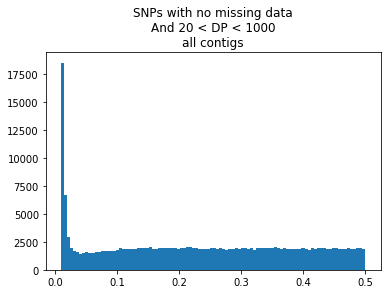

In [116]:
# plt.hist(reduced['MAF'], bins=100)
# plt.title('SNPs with no missing data\nAnd 20 < DP < 1000\nall contigs')
# plt.show()

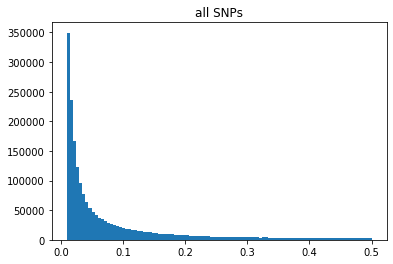

In [117]:
# plt.hist(snps['MAF'],bins=100)
# plt.title('all SNPs')
# plt.show()

#### try to reduce to X% missing data ... Result: any filtering resulted in a visibly different MAF spectrum

In [110]:
reduced.shape

(1987784, 90)

In [111]:
lview,dview = get_client()

10 10


In [112]:
def filter_perc(loci, perc=0.10):
    """Return only loci with missing data <= perc arg.
    freqcols = all cols with .FREQ in col name
    """
    import pandas
    from tqdm.notebook import tqdm as nb

    keep = []
    for locus in nb(loci):
        sums = sum([1 for freq in reduced.loc[locus,freqcols] if freq!=freq])
        if sums/len(freqcols) <= perc:
            keep.append(locus)
    return keep
dview['reduced'] = reduced
dview['freqcols'] = freqcols

In [113]:
reduced.shape

(1987784, 90)

In [114]:
nrow(reduced)/len(lview)

198778.4

In [115]:
luni(reduced['CHROM'])

24937

<center> SETTING PERC TO 0.25 MEANS NO LOCI WERE FILTERED BY MAF
    
    if I tried filtering < 25% missing data, the MAF spectrum looked weird, leaving the code inplace.

In [96]:
jobs = send_chunks(filter_perc, reduced.index.tolist(), nrow(reduced)/len(lview), lview, {'perc':0.25})
watch_async(jobs)

10
10


In [117]:
perc_above = []
for j in jobs:
    perc_above.extend(j.r)
len(perc_above)

1987784


In [116]:
print(reduced.shape)
reduced = reduced[reduced.index.isin(perc_above)].copy()
reduced.shape

(1987784, 90)

50
50


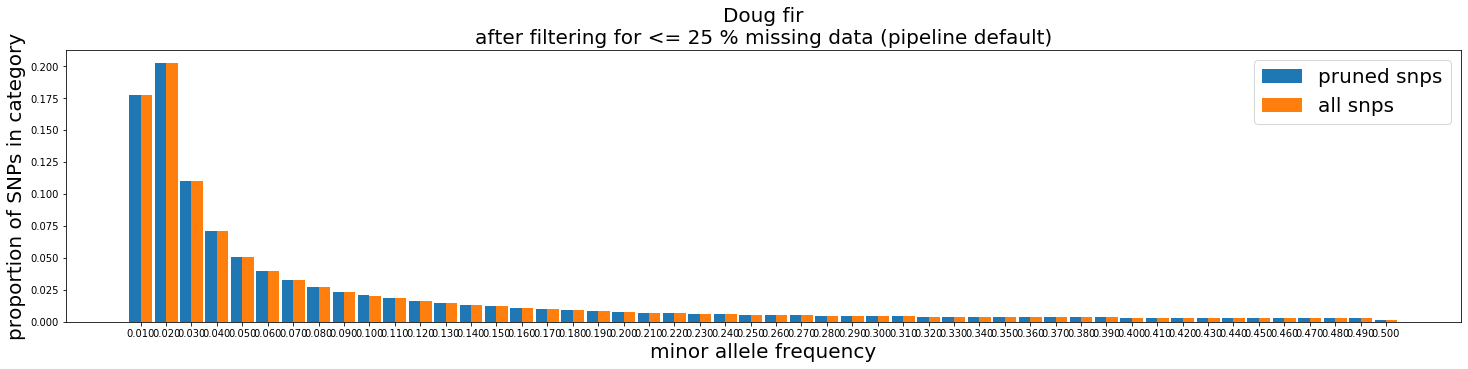

In [119]:
# this is what I used (pipeline default)
make_mafdict_fig(get_mafdict(reduced['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir\nafter filtering for <= 25 % missing data (pipeline default)')

50
50


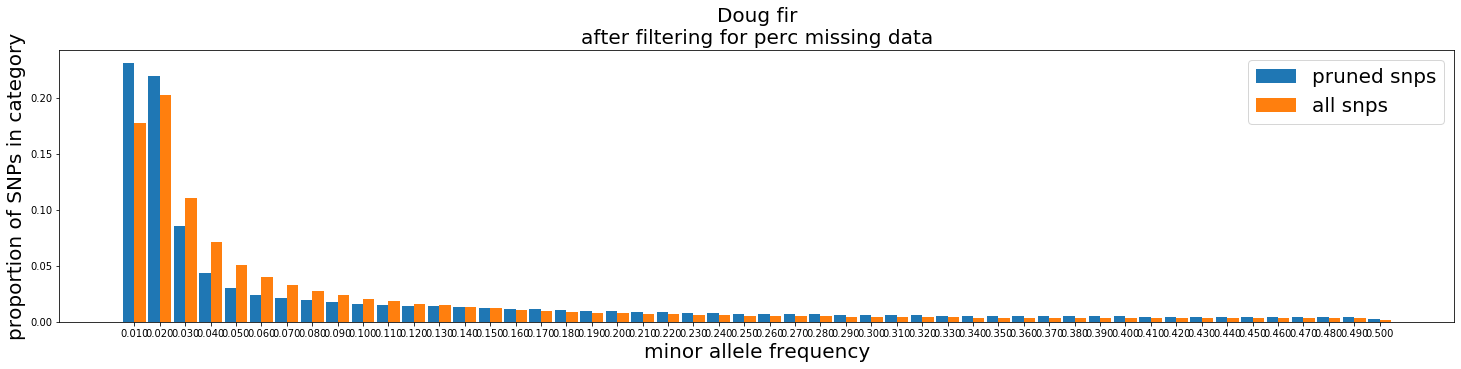

In [52]:
# this is when trying to filter for less missing data than default (eg perc=0.1)
make_mafdict_fig(get_mafdict(reduced['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir\nafter filtering for perc missing data')

#### choose one snp per contig

In [127]:
lview,dview = get_client()

30 30


In [128]:
reduced.shape

(1987784, 90)

In [124]:
def choose_random_loci(chrom_list):
    """For each chrom in chrom_list, randomly choose 1 snp."""
    from random import shuffle
    from tqdm.notebook import tqdm as nb
    
    loci = []
    for chrom in nb(chrom_list):
        chrom_snps = list(reduced[reduced['CHROM']==chrom].index)
        shuffle(chrom_snps)
        loci.append(chrom_snps[0])

    return loci
dview['reduced'] = pd.DataFrame(reduced['CHROM'])  # reload reduced

In [130]:
uni_chroms = uni(reduced['CHROM'])
len(uni_chroms)

24937

In [131]:
len(uni_chroms)/len(lview)

831.2333333333333

In [135]:
# send to choose_random_loci
# jobs = send_chunks(choose_random_loci, uni_chroms, len(uni_chroms)/len(lview), lview)
watch_async(jobs, phase='len(uni_chrom) = %s' % len(uni_chroms))

len(uni_chrom) = 24937
30
30


In [136]:
randomloci = []
for j in jobs:
    randomloci.extend(j.r)
len(randomloci) == len(uni_chroms)

True

In [137]:
len(randomloci)

24937

In [138]:
reduced = reduced[reduced.index.isin(randomloci)].copy()

In [139]:
reduced.shape

(24937, 90)

50
50


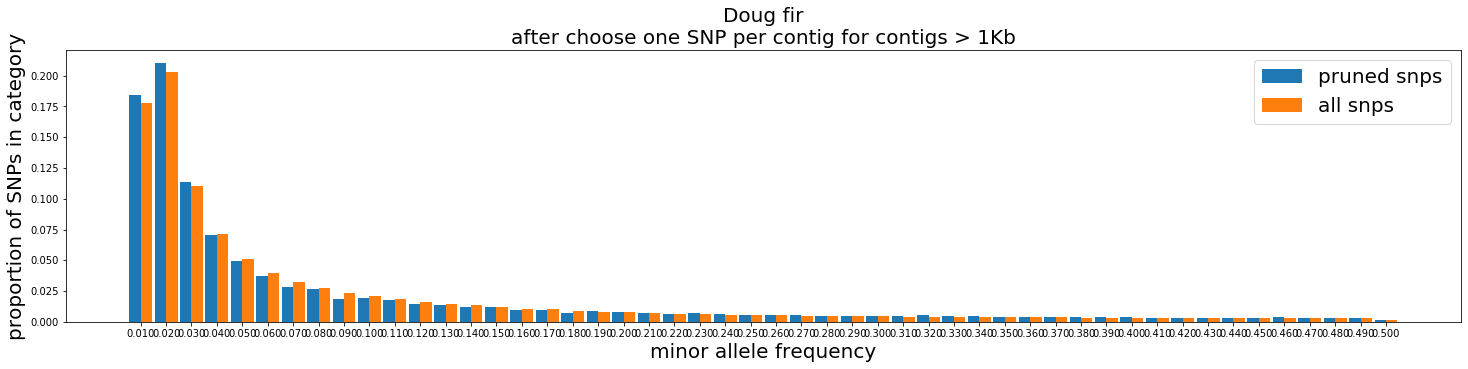

In [140]:
make_mafdict_fig(get_mafdict(reduced['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir\nafter choose one SNP per contig for contigs > 1Kb')

#### get an idea of r2 values so we can determine an empirical high-end cutoff

In [75]:
# # skip choosing 1 per contig to see what happens
# randomloci = list(nomissingloci)

In [146]:
lview,dview = get_client()

56 56


In [147]:
def getfreqs(myloci):
    """Get the population ALT frequency as a float (reported as a str in table).
    
    Returns
    -------
    list of tuples
        - first element = locus name
        - second element = pandas.Series
    """
    rets = []
    for locus in myloci:
        rets.append((locus, reduced.loc[locus, freqcols].str.replace("%", "").astype(float) / 100))
    return rets
dview['getfreqs'] = getfreqs
dview['freqcols'] = freqcols
dview['reduced'] = reduced[freqcols]

def getr2(myloci):
    from scipy.stats import pearsonr
    from numpy import logical_or
    from tqdm.notebook import tqdm as nb

    freqs = dict((locus, freqs) for (locus,freqs) in getfreqs(myloci))

    r2vals = []
    i = 0
    for locusi in nb(myloci):
        for j,locusj in enumerate(myloci):
            if i < j:
                nas = logical_or(freqs[locusi].isnull(), freqs[locusj].isnull())
                r2 = pearsonr(freqs[locusi][~nas], freqs[locusj][~nas])[0]**2
                r2vals.append(r2)
        i += 1
    return r2vals

In [148]:
jobs = send_chunks(getr2, randomloci, 250, lview)
watch_async(jobs)

100
100


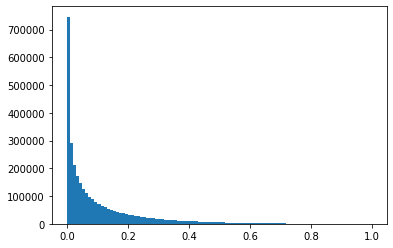

In [149]:
r2vals = []
for j in jobs:
    r2vals.extend(j.r)
plt.hist(r2vals, bins=100)
plt.show()

In [150]:
# get 99.9th percentile
r2thresh = sorted(r2vals)[math.ceil(len(r2vals)*.999)]
r2thresh

0.7746249983386226

In [151]:
# what is 99.99th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.9999)]

0.8764139976287196

In [152]:
# what is 99th percentile?
sorted(r2vals)[math.ceil(len(r2vals)*.99)]

0.5955066930267439

In [161]:
# percentiles are too high, let's see what 0.2 looks like
r2thresh = 0.2

In [162]:
for i,x in enumerate(sorted(r2vals)):
    if x > r2thresh:
        print(i)
        break

2579302


In [163]:
i/len(r2vals)  # percentile of r2thresh in r2vals

0.8323642378934066

In [164]:
sorted(r2vals)[math.ceil(len(r2vals)*(i/len(r2vals)))]

0.200000131483694

#### LD prune random loci¶

In [165]:
reduced.shape

(24937, 90)

In [166]:
len(randomloci)

24937

In [167]:
snps.shape, reduced.shape

((1995933, 178), (24937, 90))

In [168]:
freqcols = [col for col in snps if '.FREQ' in col]

In [170]:
freqs = dict((locus, freqs) for (locus,freqs) in getfreqs(randomloci))
dview['freqs'] = freqs
len(freqs)

24937

In [171]:
dview['reduced'] = None

In [172]:
len(lview)

56

In [173]:
def prune_em(compareto, locusi=None, r2thresh=0.2):
    from scipy.stats import pearsonr
    from numpy import logical_or
    
    drop = []
    for locusj in compareto:
        nas = logical_or(freqs[locusi].isnull(), freqs[locusj].isnull())
        r2 = pearsonr(freqs[locusi][~nas], freqs[locusj][~nas])[0]**2
#         print('r2 = ', r2)
        if r2 > r2thresh:
            drop.append(locusj)

    return locusi,drop

In [174]:
r2thresh

0.2

In [175]:
len(lview)

56

In [176]:
r2thresh

0.2

In [177]:
# send locus along with all needed loci for pairwise comparisons to engines
jobs = []
i = 0
for locusi in tnb(randomloci):
    tosend = randomloci[i+1:]
    jobs.append(lview.apply_async(prune_em, tosend, **{'r2thresh':r2thresh, 'locusi':locusi}))
    i += 1
watch_async(jobs)

186
24937


KeyboardInterrupt: 

In [178]:
# found = {-1: None}  # comment this out after running this the first time in case I want to interrupt and restart
# keep = list(randomloci)  # comment this out after running this the first time in case I want to interrupt and restart
maxx = -1
while maxx < (len(randomloci) - 1):
    i = 0
    for j in tnb(jobs):
        if j.ready() and i-1 in found.keys() and i not in found.keys():
            found[i] = True
            try:
                locusi, drop = j.r
            except: # CancelledError
                continue
            if locusi in keep:
                for locusj in drop:
                    if locusj in keep:
                        job_idx = randomloci.index(locusj)
    #                     print('\tcanceling ', job_idx, '. ', locusj, randomloci[job_idx])
                        jobs[job_idx].cancel()
                        keep.remove(locusj)
        i += 1
    maxx = max(found.keys())
    if maxx+1 < len(randomloci):
        update([(jobs[maxx+1].ready(), maxx, len(found.keys()), len(keep))])
        time.sleep(10)
len(keep)

(True, 24473, 24475, 3591)


3591

In [1]:
from pythonimports import *

In [2]:
# pkldump(keep, '/data/home/lindb/temp_dougfir_gea_pruned.pkl')
keep = pklload('/data/home/lindb/temp_dougfir_gea_pruned.pkl')
len(keep)

3591

In [182]:
keeping = snps[snps['locus'].isin(keep)].copy()
keeping.shape

(3591, 178)

50
50


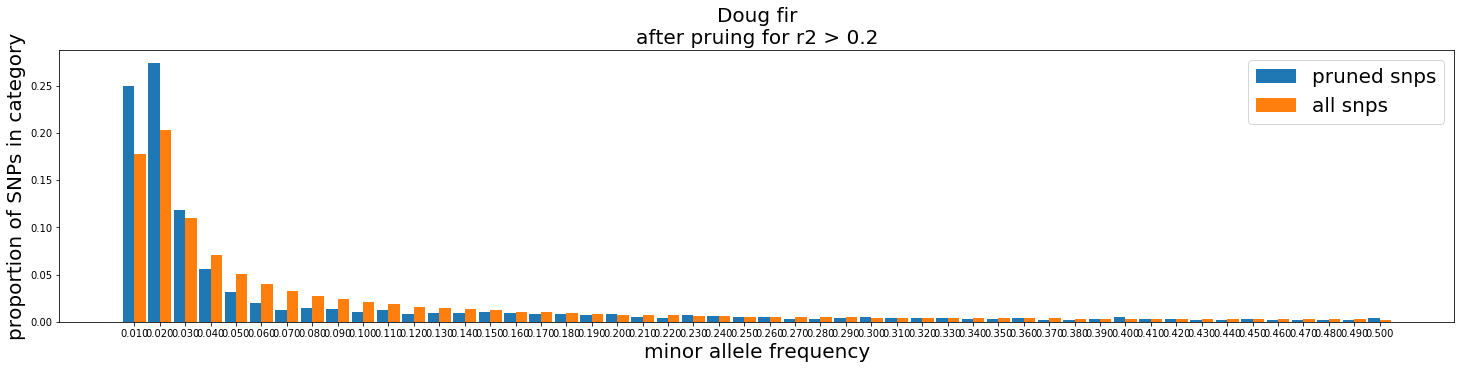

In [184]:
make_mafdict_fig(get_mafdict(keeping['AF'], roundto=2),
                 get_mafdict(snps['AF'], roundto=2),
                 title='Doug fir\nafter pruing for r2 > 0.2')

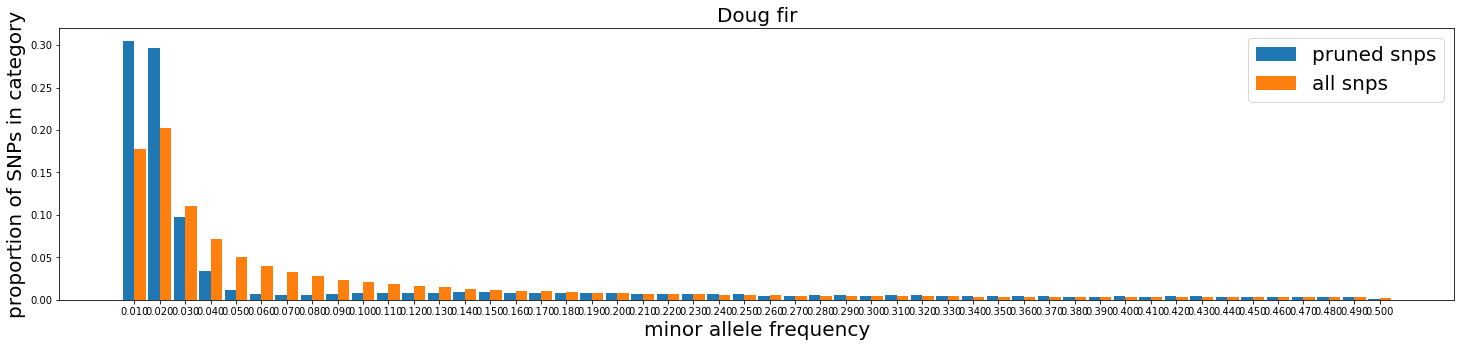

In [144]:
# this is when I had used a lower threshold of missing data.
make_mafdict_fig(pruned_mafdict, snp_mafdict, 'Doug fir')

In [185]:
len(keep)

3591

In [186]:
luni(keeping['CHROM'])

3591

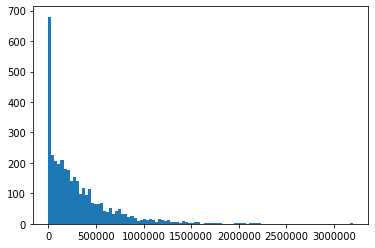

In [190]:
plt.hist([lens[chrom] for chrom in keeping['CHROM']], bins = 100)
plt.show()

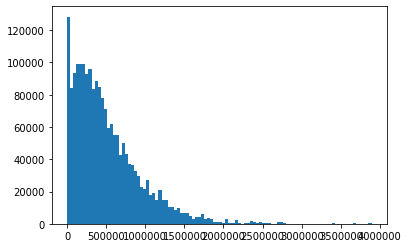

In [196]:
plt.hist([lens[chrom] for chrom in snps['CHROM'] if chrom in lens], bins=100)
plt.show()

In [193]:
len(lens), luni(snps['CHROM'])

(79910, 25448)

In [125]:
# save
baydir = makedir(op.join(mafdir, 'baypass'))
pkldump(keep, op.join(baydir, 'lessthan10perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p30.pkl'))

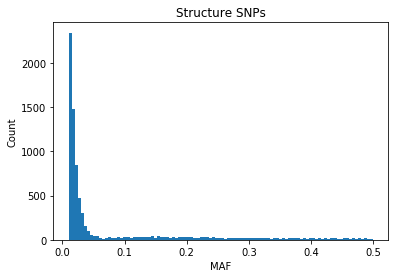

In [58]:
plt.hist(keeping['MAF'], bins=100)
plt.title('Structure SNPs')
plt.xlabel('MAF')
plt.ylabel('Count')
plt.show()

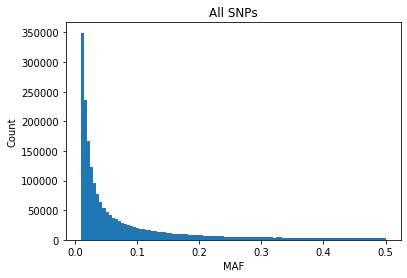

In [59]:
plt.hist(snps['MAF'], bins=100)
plt.title('All SNPs')
plt.xlabel('MAF')
plt.ylabel('Count')
plt.show()

#### get full snps df to reduce to loci in keep

In [17]:
f

'/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/03_maf-p01_RD-recalculated/DF_pooled-varscan_all_bedfiles_SNP_maf_RD-recalculated.txt'

In [18]:
linenums

6728421

In [21]:
# read in all SNPs in parallel
nrows = 50000
jobs = []
for skipto in range(0, linenums, nrows):
    jobs.append(lview.apply_async(get_skipto_df, *(f, skipto, nrows)))
watch_async(jobs)

135
135


In [23]:
snps = pd.concat([j.r for j in jobs])
snps.shape

(6728421, 711)

In [26]:
snps.index = snps['locus'].tolist()

In [28]:
filtered = snps.loc[keep, :].copy()
filtered.shape

(3591, 711)

In [29]:
filtered.head()

,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,DF_p1.GT,DF_p1.GQ,DF_p1.SDP,DF_p1.DP,DF_p1.FREQ,DF_p1.PVAL,DF_p1.AD,DF_p1.RD,DF_p18.GT,DF_p18.GQ,DF_p18.SDP,DF_p18.DP,DF_p18.FREQ,DF_p18.PVAL,DF_p18.AD,DF_p18.RD,DF_p19.GT,DF_p19.GQ,DF_p19.SDP,DF_p19.DP,DF_p19.FREQ,DF_p19.PVAL,DF_p19.AD,DF_p19.RD,DF_p2.GT,DF_p2.GQ,DF_p2.SDP,DF_p2.DP,DF_p2.FREQ,DF_p2.PVAL,DF_p2.AD,DF_p2.RD,DF_p20.GT,DF_p20.GQ,DF_p20.SDP,DF_p20.DP,DF_p20.FREQ,...,DF_p94.GT,DF_p94.GQ,DF_p94.SDP,DF_p94.DP,DF_p94.FREQ,DF_p94.PVAL,DF_p94.AD,DF_p94.RD,DF_p95.GT,DF_p95.GQ,DF_p95.SDP,DF_p95.DP,DF_p95.FREQ,DF_p95.PVAL,DF_p95.AD,DF_p95.RD,DF_p96.GT,DF_p96.GQ,DF_p96.SDP,DF_p96.DP,DF_p96.FREQ,DF_p96.PVAL,DF_p96.AD,DF_p96.RD,DF_p97.GT,DF_p97.GQ,DF_p97.SDP,DF_p97.DP,DF_p97.FREQ,DF_p97.PVAL,DF_p97.AD,DF_p97.RD,DF_p98.GT,DF_p98.GQ,DF_p98.SDP,DF_p98.DP,DF_p98.FREQ,DF_p98.PVAL,DF_p98.AD,DF_p98.RD,DF_p17.GT,DF_p17.GQ,DF_p17.SDP,DF_p17.DP,DF_p17.FREQ,DF_p17.PVAL,DF_p17.AD,DF_p17.RD,locus,MAF
jcf7190000127863-64936,jcf7190000127863,64936,A,G,0.828873,-10.0,SNP,PASS,72,0,27,60,0,G/G,255.0,84,84.0,84.52%,2.026700e-34,71.0,13.0,A/G,205.0,59,59.0,77.97%,2.911200e-21,46.0,13.0,G/G,255.0,95,95.0,86.32%,2.270000e-40,82.0,13.0,G/G,110.0,29,29.0,82.76%,9.254400e-12,24.0,5.0,A/G,130.0,49,49.0,65.31%,...,G/G,255.0,55,55.0,94.55%,3.131700e-28,52.0,3.0,G/G,255.0,92,92.0,85.87%,9.693500e-39,79.0,13.0,A/G,255.0,79,79.0,75.95%,3.740900e-27,60.0,19.0,G/G,255.0,96,96.0,83.33%,2.636200e-38,80.0,16.0,G/G,255.0,81,81.0,90.12%,1.930100e-37,73.0,8.0,A/G,110.0,36,36.0,72.22%,9.211800e-12,26.0,10.0,jcf7190000127863-64936,0.171127
jcf7190000135978-38057,jcf7190000135978,38057,T,A,0.011262,-10.0,SNP,PASS,54,85,2,0,0,T/T,66.0,42,42.0,2.38%,5.000000e-01,1.0,41.0,T/T,111.0,60,60.0,0%,1.000000e+00,0.0,60.0,T/T,167.0,98,98.0,1.02%,5.000000e-01,1.0,97.0,T/T,25.0,21,21.0,9.52%,2.439000e-01,2.0,19.0,T/T,74.0,40,40.0,0%,...,T/T,96.0,52,52.0,0%,1.000000e+00,0.0,52.0,T/T,100.0,54,54.0,0%,1.000000e+00,0.0,54.0,T/T,97.0,51,51.0,0%,1.000000e+00,0.0,51.0,T/T,97.0,51,51.0,0%,1.000000e+00,0.0,51.0,T/T,77.0,54,54.0,3.7%,2.476600e-01,2.0,52.0,T/T,44.0,30,30.0,3.33%,5.000000e-01,1.0,29.0,jcf7190000135978-38057,0.011262
jcf7190000149428-167816,jcf7190000149428,167816,T,C,0.032015,-10.0,SNP,PASS,95,60,27,0,0,T/T,295.0,157,157.0,0%,1.000000e+00,0.0,157.0,T/C,41.0,69,69.0,18.84%,6.550100e-05,13.0,56.0,T/C,48.0,78,78.0,19.23%,1.451200e-05,15.0,63.0,T/T,59.0,32,32.0,0%,1.000000e+00,0.0,32.0,T/C,19.0,30,30.0,NaN,...,T/T,130.0,83,83.0,2.41%,2.484800e-01,2.0,81.0,T/T,336.0,179,179.0,0%,1.000000e+00,0.0,179.0,T/T,197.0,106,106.0,0%,1.000000e+00,0.0,106.0,T/T,235.0,125,125.0,0%,1.000000e+00,0.0,125.0,T/T,209.0,112,112.0,0%,1.000000e+00,0.0,112.0,T/T,66.0,36,36.0,0%,1.000000e+00,0.0,36.0,jcf7190000149428-167816,0.032015
jcf7190000033887-69342,jcf7190000033887,69342,T,C,0.112383,-10.0,SNP,PASS,82,22,65,0,0,T/C,27.0,107,107.0,8.41%,1.639200e-03,9.0,98.0,T/C,31.0,86,86.0,11.63%,7.402300e-04,10.0,76.0,T/C,27.0,114,114.0,7.89%,1.657600e-03,9.0,105.0,T/T,25.0,25,25.0,12%,1.173500e-01,3.0,22.0,T/T,62.0,40,40.0,2.5%,...,T/T,164.0,88,88.0,0%,1.000000e+00,0.0,88.0,T/C,40.0,113,113.0,11.5%,8.469500e-05,13.0,100.0,T/C,41.0,92,92.0,14.13%,7.743100e-05,13.0,79.0,T/C,54.0,101,101.0,16.83%,3.661600e-06,17.0,84.0,T/T,117.0,81,81.0,3.7%,1.226700e-01,3.0,78.0,T/C,15.0,29,29.0,NaN,2.591700e-02,5.0,24.0,jcf7190000033887-69342,0.112383
jcf7190000139702-166207,jcf7190000139702,166207,G,A,0.011277,-10.0,SNP,PASS,394,58,29,0,0,G/A,95.0,558,558.0,5.56%,3.033900e-10,31.0,527.0,G/G,543.0,289,289.0,0%,1.000000e+00,0.0,289.0,G/G,640.0,342,342.0,0%,1.000000e+00,0.0,342.0,G/A,15.0,74,74.0,NaN,2.914600e-02,5.0,69.0,G/G,175.0,93,93.0,0%,...,G/G,614.0,327,327.0,0%,1.000000e+00,0.0,327.0,G/G,1438.0,768,768.0,0%,1.000000e+00,0.0,768.0,G/A,24.0,499,499.0,1.6%,3.797400e-03,8.0,491.0,G/A,45.0,554,554.0,2.71%,2.772300e-05,15.0,539.0,G/G,700.0,374,374.0,0%,1.000000e+00,0.0,374.0,G/G,258.0,162,162.0,1.85%,1.238400e-01,3.0,159.0,jcf7190000139702-166207,0.011277


In [31]:
baydir = '/data/projects/pool_seq/DF_datasets/DF_pooled_GEA/DF_pooled/snpsANDindels/03_maf-p01_RD-recalculated/baypass'
pkldump(keep, op.join(baydir,
                      'baseline-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p20.pkl'))

In [146]:
# # moved this and all files like it to baydir/bad_maf_spectrum
# filtered.to_csv(op.join(baydir, 'lessthan10perc-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p30_table.txt'),
#                 sep='\t', index=False)

In [32]:
filtered.to_csv(op.join(baydir, 'baseline-missing-data_20-dp-1000_random-snps_1-per-contig-gt1Kbp_r2-lessthan-p20_table.txt'),
                sep='\t', index=False)

In [33]:
del snps

In [34]:
dview['df'] = None